In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import mdtraj
import deep_boltzmann
from deep_boltzmann.networks.training import MLTrainer, FlexibleTrainer
from deep_boltzmann.networks.invertible import invnet, EnergyInvNet, InvNet
from deep_boltzmann.openmmutils import save_latent_samples_as_trajectory
from deep_boltzmann.models.openmm import OpenMMEnergy
import mdtraj as md
from simtk import openmm, unit

import sys, os, shutil
import tensorflow as tf

In [2]:
from IPython import display
display.set_matplotlib_formats("svg")

In [3]:
print("Tensorflow Version:", tf.__version__)

Tensorflow Version: 2.5.0


In [4]:
pdb_model = mdtraj.load_pdb('pdz3_rat_apo_fixed.pdb')

In [5]:
traj = mdtraj.load("implicit_traj.h5")
sim_x = traj.xyz
print(sim_x.shape)

(100000, 1655, 3)


In [6]:
def setup_protein(pdbmodel_dir):
    """ Sets up protein Topology and Energy Model

    Returns
    -------
    top : mdtraj Topology object
        Protein topology
    energy : Energy object
        Energy model

    """
    # 4C in KIW's experiment
    INTEGRATOR_ARGS = (277*unit.kelvin, 1.0/unit.picoseconds, 2.0*unit.femtoseconds)

    from simtk.openmm import app
    pdb = app.PDBFile(pdbmodel_dir)
    forcefield = openmm.app.ForceField('amber99sb.xml', 'amber99_obc.xml') #implicit Solvent

    system = forcefield.createSystem(pdb.topology,removeCMMotion=False,
                                     nonbondedMethod=app.CutoffNonPeriodic, nonbondedCutoff=1.0*unit.nanometers,
                                     constraints=None, rigidWater=True)
    integrator = openmm.LangevinIntegrator(277*unit.kelvin, 1.0/unit.picoseconds, 2.0*unit.femtoseconds)
    simulation = openmm.app.Simulation(pdb.topology, system, integrator)

    protein_omm_energy = OpenMMEnergy(system,
                                   openmm.LangevinIntegrator,
                                   unit.nanometers,
                                   n_atoms=md.Topology().from_openmm(simulation.topology).n_atoms,
                                   openmm_integrator_args=INTEGRATOR_ARGS)

    mdtraj_topology = md.Topology().from_openmm(pdb.topology)
    return mdtraj_topology, protein_omm_energy

def get_indices(top, cartesian_CYS=True):
    """ Returns Cartesian and IC indices

    Returns
    -------
    cart : array
        Cartesian atom selection
    Z : array
        Z index matrix

    """
    from deep_boltzmann.models.proteins import mdtraj2Z
    cartesian = ['CA', 'C', 'N']
    cart = top.select(' '.join(["name " + s for s in cartesian]))
    if cartesian_CYS:
        Z_, _carts = mdtraj2Z(top,  cartesian="resname CYS and mass>2 and sidechain")
        Z_ = np.array(Z_)
        cart = np.sort(np.concatenate((cart,_carts)))
    else:
        Z_ = np.array(mdtraj2Z(top))
    return cart, Z_

In [7]:
def train_ML(bg, xtrain, epochs, batch_sizes):
    trainer_ML = MLTrainer(bg, lr=0.001)
    for batch_size in batch_sizes:
        trainer_ML.train(xtrain, epochs=epochs, batch_size=batch_size)
    return trainer_ML

In [8]:
def train_KL(bg, xtrain, epochs, high_energies, w_KLs, stage=0, rc_dims=None, rc_func=None, rc_min=None, 
             rc_max=None, w_RC=0., w_L2_angle=0., loss_track=[], file_name="./BG_intermediate_model_saved_TF2_implicit.pkl"):
    #trainers_KL_state3 = []
    for current_stage in range(stage, len(epochs)):
        print('-----------------------')
        print(high_energies[current_stage], w_KLs[current_stage])
        sys.stdout.flush()
        flextrainer = FlexibleTrainer(bg, lr=0.0001, batch_size=2000,
                                      high_energy=high_energies[current_stage], max_energy=1e20,
                                      w_KL=w_KLs[current_stage], w_ML=1, weigh_ML=False, w_RC=w_RC,
                                      rc_func=rc_func, rc_min=np.array(rc_min), rc_max=np.array(rc_max),
                                      w_L2_angle=w_L2_angle, 
                                      rc_dims=rc_dims)
        flextrainer.train(xtrain, epochs=epochs[current_stage])
        #trainers_KL_state3.append(flextrainer)
        loss_track.extend(flextrainer.loss_train)

        # Analyze
        samples_z = np.random.randn(2000, bg.dim)
        samples_x = bg.Tzx.predict(samples_z)
        samples_e = bg.energy_model.energy(samples_x)
        energy_violations = [np.count_nonzero(samples_e > E) for E in high_energies]
        print('Energy violations:')
        for E, V in zip(high_energies, energy_violations):
            print(V, '\t>\t', E)
        sys.stdout.flush()

        # SAVE
        bg.save(file_name)
        saveconfig = {}
        saveconfig['stage'] = current_stage
        #np.savez_compressed('config_save.npz', **saveconfig)
        print('Intermediate result saved')
        sys.stdout.flush()
    return loss_track

### Set up a BG network

In [9]:
top, mm_pdz = setup_protein('pdz3_rat_apo_fixed.pdb')

In [10]:
# Superimpose frames and reshuffle 
nframes = sim_x.shape[0]
dim = sim_x.shape[1]*sim_x.shape[2]
sim_x_traj = mdtraj.Trajectory(sim_x.reshape((nframes, int(dim/3), 3)), top)
sim_x_traj = sim_x_traj.superpose(sim_x_traj[0], atom_indices=top.select('backbone'))
sim_x = sim_x_traj.xyz.reshape((nframes, -1))
np.random.shuffle(sim_x)

In [11]:
# Get indices for dimensions represented by cartesian and internal coordinates respectively
CartIndices, ZIndices = get_indices(top, cartesian_CYS=False)

In [ ]:
# Construct Boltzmann Generator object 
bg = invnet(dim, 'R'*8, energy_model=mm_pdz,
            ic=np.asarray(ZIndices,dtype=np.int), ic_cart=np.asarray(CartIndices,dtype=np.int), ic_norm=sim_x,
            nl_layers=4, nl_hidden=[256, 128, 256], nl_activation='relu', nl_activation_scale='tanh')
print('BG constructed\n')
sys.stdout.flush()

### ML Training with MD-generated Dataset, longer Epoch

In [23]:
# Perform ML training -- 4 epochs with increasing batch sizes
epochs_ML = 2000
batch_sizes_ML = [256, 512, 1024, 1024]
trainer_ML = train_ML(bg, sim_x, epochs_ML, batch_sizes_ML)
bg.save('./BG_save_after_ML_TF2_implicit.pkl')

print('ML training done\n')
sys.stdout.flush()

Epoch 0/2000 ML Loss Value -17895.9023 
Epoch 1/2000 ML Loss Value -18475.8633 
Epoch 2/2000 ML Loss Value -18477.5703 
Epoch 3/2000 ML Loss Value -18506.7852 
Epoch 4/2000 ML Loss Value -18585.9023 
Epoch 5/2000 ML Loss Value -18615.2969 
Epoch 6/2000 ML Loss Value -18650.9922 
Epoch 7/2000 ML Loss Value -18686.2969 
Epoch 8/2000 ML Loss Value -18691.5176 
Epoch 9/2000 ML Loss Value -18700.6543 
Epoch 10/2000 ML Loss Value -18705.9297 
Epoch 11/2000 ML Loss Value -18713.4355 
Epoch 12/2000 ML Loss Value -18720.5645 
Epoch 13/2000 ML Loss Value -18726.2070 
Epoch 14/2000 ML Loss Value -18730.4336 
Epoch 15/2000 ML Loss Value -18732.9062 
Epoch 16/2000 ML Loss Value -18721.3379 
Epoch 17/2000 ML Loss Value -18729.0703 
Epoch 18/2000 ML Loss Value -18744.5508 
Epoch 19/2000 ML Loss Value -18732.8809 
Epoch 20/2000 ML Loss Value -18738.8359 
Epoch 21/2000 ML Loss Value -18738.1035 
Epoch 22/2000 ML Loss Value -18760.6172 
Epoch 23/2000 ML Loss Value -18755.2578 
Epoch 24/2000 ML Loss Valu

KeyboardInterrupt: 

In [12]:
bg = InvNet.load('./BG_save_after_ML_TF2_implicit.pkl')

Before connect
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Done xz
Done zx


In [13]:
# two more ML Training
epochs_ML = 2000
batch_sizes_ML = [1024, 1024]
trainer_ML = train_ML(bg, sim_x, epochs_ML, batch_sizes_ML)
bg.save('./BG_save_after_ML_TF2_implicit.pkl')
print('ML training done\n')
sys.stdout.flush()

Epoch 0/2000 ML Loss Value -19560.8320 
Epoch 1/2000 ML Loss Value -18080.0195 
Epoch 2/2000 ML Loss Value -19205.6797 
Epoch 3/2000 ML Loss Value -19139.2539 
Epoch 4/2000 ML Loss Value -19101.2070 
Epoch 5/2000 ML Loss Value -19121.2109 
Epoch 6/2000 ML Loss Value -19147.3926 
Epoch 7/2000 ML Loss Value -19179.1543 
Epoch 8/2000 ML Loss Value -19201.6582 
Epoch 9/2000 ML Loss Value -19221.1465 
Epoch 10/2000 ML Loss Value -19238.7578 
Epoch 11/2000 ML Loss Value -19249.9688 
Epoch 12/2000 ML Loss Value -19262.6270 
Epoch 13/2000 ML Loss Value -19279.0352 
Epoch 14/2000 ML Loss Value -19287.6992 
Epoch 15/2000 ML Loss Value -19302.0605 
Epoch 16/2000 ML Loss Value -19310.6660 
Epoch 17/2000 ML Loss Value -19319.5508 
Epoch 18/2000 ML Loss Value -19330.1562 
Epoch 19/2000 ML Loss Value -19339.5469 
Epoch 20/2000 ML Loss Value -19363.8809 
Epoch 21/2000 ML Loss Value -19364.2188 
Epoch 22/2000 ML Loss Value -19366.0898 
Epoch 23/2000 ML Loss Value -19373.9102 
Epoch 24/2000 ML Loss Valu

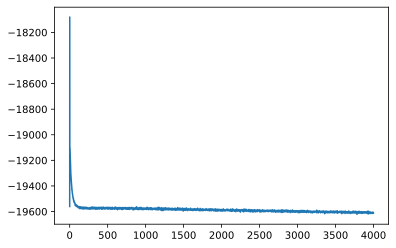

In [16]:
plt.plot(trainer_ML.loss_train)
plt.show()

### KL + ML Flexible Training

In [14]:
bg = EnergyInvNet.load('./BG_save_after_ML_TF2_implicit.pkl', mm_pdz)

Before connect
Done xz
Done zx


In [15]:
saveconfig = {}
# Train KL
saveconfig['stage'] = 0

epochs_KL     = [  15,   15,   15,   15,   15,   15,  20,  20,  30, 50, 50, 300]
high_energies = [1e10,  1e9,  1e8,  1e7,  1e6,  1e5,  1e5,  1e5,  5e4,  5e4,  2e4,  2e4]
w_KLs         = [1e-12, 1e-6, 1e-5, 1e-4, 1e-3, 1e-3, 5e-3, 1e-3, 5e-3, 5e-3, 0.01, 0.01]
loss_track = train_KL(bg,  sim_x, epochs_KL, high_energies, w_KLs, stage = saveconfig['stage'],w_L2_angle=1.0, loss_track=[],
                     file_name="./BG_intermediate_model_saved_TF2_implicit.pkl")

-----------------------
10000000000.0 1e-12
Epoch 0/15 Overall Loss 4558.5283 ML Loss -19607.4883 KL Loss 1013316480.0000 L2 Angle Loss 24166.0137 
Epoch 1/15 Overall Loss -5203.2139 ML Loss -19602.4492 KL Loss 982247680.0000 L2 Angle Loss 14399.2363 
Epoch 2/15 Overall Loss -10849.5332 ML Loss -19590.8887 KL Loss 838704128.0000 L2 Angle Loss 8741.3535 
Epoch 3/15 Overall Loss -12763.4443 ML Loss -19557.8633 KL Loss 897703936.0000 L2 Angle Loss 6794.4219 
Epoch 4/15 Overall Loss -14887.2783 ML Loss -19528.9531 KL Loss 905886912.0000 L2 Angle Loss 4641.6763 
Epoch 5/15 Overall Loss -15587.4785 ML Loss -19494.0801 KL Loss 837127232.0000 L2 Angle Loss 3906.6011 
Epoch 6/15 Overall Loss -16868.3281 ML Loss -19460.5918 KL Loss 959855552.0000 L2 Angle Loss 2592.2576 
Epoch 7/15 Overall Loss -17112.6094 ML Loss -19416.8340 KL Loss 916241664.0000 L2 Angle Loss 2304.2227 
Epoch 8/15 Overall Loss -17753.0957 ML Loss -19374.9473 KL Loss 871340352.0000 L2 Angle Loss 1621.8507 
Epoch 9/15 Overall L

In [17]:
loss_track_array = np.array(loss_track)

In [20]:
fig,ax = plt.subplots(1,2, figsize=[12,5])

ax[0].plot(loss_track_array[:,1])
ax[0].set_ylim(-20000,-19000)
ax[0].set_xlabel("Epoches")
ax[0].set_ylabel("ML Loss")

ax[1].plot(loss_track_array[:,2])
ax[1].set_ylim(17000,23000)
ax[1].set_xlabel("Epoches")
ax[1].set_ylabel("KL Loss")

#ax[2].plot(loss_track_array[:,3])
#ax[2].set_ylim(-10,1000)
plt.show()

### Visualization

In [21]:
%%time
zsamples, xsamples, zenergys, xenergys, logw = bg.sample(nsample=10000)

CPU times: user 1min 30s, sys: 41.3 s, total: 2min 11s
Wall time: 44.7 s


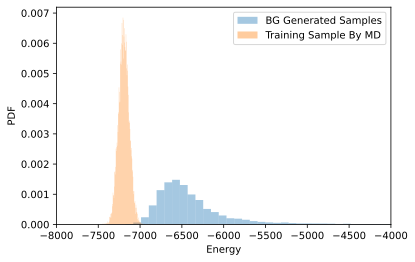

In [23]:
plt.hist(xenergys[xenergys<5000],bins=128,density=True,alpha=0.4, label="BG Generated Samples");
plt.hist(mm_pdz.energy(sim_x[::10,:]), bins=128,density=True,alpha=0.4, label='Training Sample By MD');
plt.xlabel("Energy")
plt.ylabel("PDF")
plt.legend()
plt.xlim(-8000,-4000)
plt.show()

#### LEU44 and SER45 CA

In [24]:
atoms_list = list(traj.top.atoms)
atoms_list = [str(i) for i in atoms_list]
w_ILE44CA = atoms_list.index("LEU44-CA")
w_SER45CA = atoms_list.index("SER45-CA")

In [25]:
MDcoords_ILE44CA = sim_x.reshape((100000, 1655, 3))[:,w_ILE44CA,:]
BGcoords_ILE44CA = xsamples.reshape((10000,1655,3))[:,w_ILE44CA,:]

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(MDcoords_ILE44CA)

PCA(n_components=2)

In [27]:
rd_index = np.random.choice(100000, 10000, replace=False)
rd_index2 = np.random.choice(10000, 1000, replace=False)

In [28]:
MD44_PC = pca.fit_transform(MDcoords_ILE44CA)
BG44_PC = pca.fit_transform(BGcoords_ILE44CA)

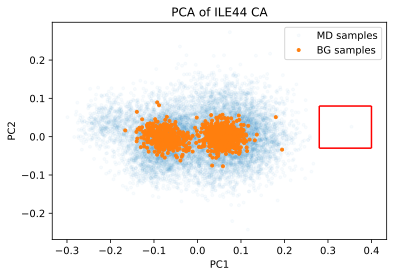

In [29]:
plt.plot(MD44_PC[rd_index,0],MD44_PC[rd_index,1], '.', alpha=0.03, label="MD samples")
plt.plot(BG44_PC[rd_index2,0],BG44_PC[rd_index2,1], '.', alpha=1, label="BG samples")
#plt.plot(BG1p544_PC[rd_index2,0],BG1p544_PC[rd_index2,1], '.', alpha=0.02, label="BG samples, higher temperature")
#plt.plot(BG2044_PC[rd_index2,0],BG2044_PC[rd_index2,1], '.', alpha=0.1, label="BG samples, Even higher")
plt.vlines(0.28, -0.03, 0.08, colors='red')
plt.vlines(0.40, -0.03, 0.08, colors='red')
plt.hlines(-0.03, 0.28, 0.40, colors='red')
plt.hlines(0.08, 0.28, 0.40, colors='red')
plt.title("PCA of ILE44 CA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In [36]:
print(MD44_PC.shape)
w_ex = np.argwhere((MD44_PC[:,0] > 0.28) & (MD44_PC[:,0] < 0.40) & (MD44_PC[:,1] > -0.03) & (MD44_PC[:,1] < 0.08)).reshape(-1)
w_ground = np.argwhere(MD44_PC[:,0] < 0.12).reshape(-1)

(100000, 2)


In [37]:
print(w_ex.shape, w_ground.shape) # excited state index

(4462,) (87587,)


In [26]:
xsample_ex = sim_x[w_ex]
zsample_ex = bg.transform_xz(xsample_ex)

In [27]:
zsample_ex, logRxz_ex = bg.TxzJ.predict(xsample_ex)
zsample_ground, logRxz_ground = bg.TxzJ.predict(xsamples)

In [28]:
print("Enegy in z space:", np.sum(zsample_ex**2, axis=1).mean(), np.sum(zsample_ground**2, axis=1).mean())

Enegy in z space: 4912.103 4959.854


In [29]:
print("Entropy:", np.mean(logRxz_ex), np.mean(logRxz_ground))

Entropy: 21986.656 23705.041


In [30]:
save_latent_samples_as_trajectory(xsamples[1000:1500], top, filename="BGTF2_pdz3_batchsample_longML.pdb")

<mdtraj.Trajectory with 500 frames, 1655 atoms, 110 residues, without unitcells at 0x7fc6f1866690>

#### More samples

In [31]:
%%time
zsamples2, xsamples2, zenergys2, xenergys2, logw2 = bg.sample(nsample=100000)

CPU times: user 12min 17s, sys: 6min 43s, total: 19min 1s
Wall time: 4min 47s


In [33]:
BG2coords_ILE44CA = xsamples2.reshape((100000,1655,3))[:,w_ILE44CA,:]

In [34]:
BG244_PC = pca.fit_transform(BG2coords_ILE44CA)

In [39]:
plt.plot(MD44_PC[rd_index,0],MD44_PC[rd_index,1], '.', alpha=0.03, label="MD samples")
plt.plot(BG244_PC[rd_index,0],BG244_PC[rd_index,1], '.', alpha=1, label="BG samples")
#plt.plot(BG1p544_PC[rd_index2,0],BG1p544_PC[rd_index2,1], '.', alpha=0.02, label="BG samples, higher temperature")
#plt.plot(BG2044_PC[rd_index2,0],BG2044_PC[rd_index2,1], '.', alpha=0.1, label="BG samples, Even higher")
plt.vlines(0.28, -0.03, 0.08, colors='red')
plt.vlines(0.40, -0.03, 0.08, colors='red')
plt.hlines(-0.03, 0.28, 0.40, colors='red')
plt.hlines(0.08, 0.28, 0.40, colors='red')
plt.title("PCA of ILE44 CA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()